2018 Edition

# Building a music recommender system

As its name implies, a recommender system is a tool that helps predicting what a user may or may not like among a list of given items. In some sense, you can view this as an alternative to content search, as recommendation engines help users discover products or content that they may not come across otherwise. For example, Facebook suggests friends and pages to users. Youtube recommends videos which users may be interested in. Amazon suggests the products which users may need... Recommendation engines engage users to services, can be seen as a revenue optimization process, and in general help maintaining interest in a service.

In this notebook, we study how to build a simple recommender system: we focus on music recommendations, and we use a simple algorithm to predict which items users might like, that is called ALS, alternating least squares.

## Goals

In this lecture, we expect students to:

- Revisit (or learn) recommender algorithms

- Understand the idea of Matrix Factorization and the ALS algorithm (serial and parallel versions)

- Build a simple model for a real usecase: music recommender system

- Understand how to validate the results

## Steps

We assume students to work outside lab hours on the learning material. These are the steps by which we guide students, during labs, to build a good basis for the end-to-end development of a recommender system:

* Inspect the data using Spark SQL, and build some basic, but very valuable knowledge about the information we have at hand
* Formally define what is a sensible algorithm to achieve our goal: given the "history" of user taste for music, recommend new music to discover. Essentialy, we want to build a statistical model of user preferences such that we can use it to "predict" which additional music the user could like
* With our formal definition at hand, we will learn different ways to implement such an algorithm. Our goal here is to illustrate what are the difficulties to overcome when implementing a (parallel) algorithm
* Finally, we will focus on an existing implementation, available in the Apache Spark MLLib, which we will use out of the box to build a reliable statistical model

Now, you may think at this point we will be done!

Well, you'd better think twice: one important topic we will cover in all our Notebooks is **how to validate the results we obtain**, and **how to choose good parameters to train models** especially when using an "opaque" library for doing the job. As a consequence, we will focus on the statistical validation of our recommender system.


# 1. Data

Understanding data is one of the most important part when designing any machine learning algorithm. In this notebook, we will use a data set published by Audioscrobbler - a music recommendation system for last.fm. Audioscrobbler is also one of the first internet streaming radio sites, founded in 2002. It provided an open API for “scrobbling”, or recording listeners’ plays of artists’ songs. last.fm used this information to build a powerful music recommender engine.

## 1.1. Data schema

Unlike a rating dataset which contains information about users' preference for products (one star, 3 stars, and so on), the datasets from Audioscrobbler only has information about events: specifically, it keeps track of how many times a user played songs of a given artist and the names of artists. That means it carries less information than a rating: in the literature, this is called explicit vs. implicit ratings.

### Reading material

- [Implicit Feedback for Inferring User Preference: A Bibliography](http://people.csail.mit.edu/teevan/work/publications/papers/sigir-forum03.pdf)
- [Comparing explicit and implicit feedback techniques for web retrieval: TREC-10 interactive track report](http://trec.nist.gov/pubs/trec10/papers/glasgow.pdf)
- [Probabilistic Models for Data Combination in Recommender Systems](http://mlg.eng.cam.ac.uk/pub/pdf/WilGha08.pdf)

The data we use in this Notebook is available in 3 files (these files are stored in our HDFS layer, in the directory  ```/datasets/lastfm```):

- **`user_artist_data.txt`**: It contains about 140,000+ unique users, and 1.6 million unique artists. About 24.2 million users’ plays of artists’ are recorded, along with their count. It has 3 columns separated by spaces: 

| UserID | ArtistID | PlayCount |
|----|----|----|
| ...|...|...|


- **`artist_data.txt`** : It prodives the names of each artist by their IDs. It has 2 columns separated by tab characters (`\t`).

| ArtistID | Name |
|---|---|
|...|...|

- **`artist_alias.txt`**: Note that when plays are scrobbled, the client application submits the name of the artist being played. This name could be misspelled or nonstandard. For example, "The Smiths", "Smiths, The", and "the smiths" may appear as distinct artist IDs in the data set, even though they are plainly the same. `artist_alias.txt` maps artist IDs that are known misspellings or variants to the canonical ID of that artist. The data in this file has 2 columns separated by tab characters (`\t`).

| MisspelledArtistID | StandardArtistID |
|---|---|
|...|...|



## 1.2. Understanding data: simple descriptive statistic

In order to choose or design a suitable algorithm for achieving our goals, given the data we have, we should first understand data characteristics. To start, we import the necessary packages to work with regular expressions, Data Frames, and other nice features of our programming environment.

In [1]:
import os
import sys
import re
import random
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql.types import *
from pyspark.sql import Row
from pyspark.sql.functions import *

%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from time import time

#sc =SparkContext()
sqlContext = SQLContext(sc)

base = "/datasets/lastfm/"

### Question 1

#### Question 1.0 (Non-grading)
<div class="alert alert-info">
Using SPARK SQL, load data from `/datasets/lastfm/user_artist_data.txt` and show the first 20 entries (via function `show()`).
</div>

For this Notebook, from a programming point of view, we are given the schema for the data we use, which is as follows:

```
userID: long int
artistID: long int
playCount: int
```

Each line of the dataset contains the above three fields, separated by a "white space".

In [2]:
userArtistDataSchema = StructType([ \
    StructField("userID", LongType(), True), \
    StructField("artistID", LongType(), True), \
    StructField("playCount", IntegerType(), True)])

userArtistDF = sqlContext.read \
    .format('com.databricks.spark.csv') \
    .options(header='false', delimiter=' ') \
    .load(base + "user_artist_data.txt", schema = userArtistDataSchema) \
    .cache()

# we can cache an Dataframe to avoid computing it from the beginning everytime it is accessed.
userArtistDF.cache()

userArtistDF.show()

+-------+--------+---------+
| userID|artistID|playCount|
+-------+--------+---------+
|1000002|       1|       55|
|1000002| 1000006|       33|
|1000002| 1000007|        8|
|1000002| 1000009|      144|
|1000002| 1000010|      314|
|1000002| 1000013|        8|
|1000002| 1000014|       42|
|1000002| 1000017|       69|
|1000002| 1000024|      329|
|1000002| 1000025|        1|
|1000002| 1000028|       17|
|1000002| 1000031|       47|
|1000002| 1000033|       15|
|1000002| 1000042|        1|
|1000002| 1000045|        1|
|1000002| 1000054|        2|
|1000002| 1000055|       25|
|1000002| 1000056|        4|
|1000002| 1000059|        2|
|1000002| 1000062|       71|
+-------+--------+---------+
only showing top 20 rows



#### Question 1.1: 
<div class="alert alert-info">
How many distinct users do we have in our data? 
</div>

In [3]:
uniqueUsers = userArtistDF.select("userID").distinct().count()
print("Total n. of users: ", uniqueUsers)

Total n. of users:  148111


#### Question 1.2
<div class="alert alert-info">
How many distinct artists do we have in our data ?
</div>

In [4]:
uniqueArtists = userArtistDF.select("artistID").distinct().count()
print("Total n. of artists: ", uniqueArtists)

Total n. of artists:  1631028


#### Question 1.3
<div class="alert alert-info">
One limitation of Spark MLlib's ALS implementation - which we will use later - is that it requires IDs for users and items to be nonnegative 32-bit integers. This means that IDs larger than `Integer.MAX_VALUE`, or `2147483647`, can't be used. So we need to check whether this data set conforms to the strict requirements of our library.  

What are the maximum and minimum values of column `userID` ?  
</div>

In [5]:
userArtistDF.select(min("userID"),max("userID")).show()

+-----------+-----------+
|min(userID)|max(userID)|
+-----------+-----------+
|         90|    2443548|
+-----------+-----------+



<div class="alert alert-warning">The minimum userID value and the maximum userID value in this dataset are both less than Integer.MAX_VALUE and both of them, clearly, that greater than ZERO. Actually, the out-of-range problem might happen when the number of users is greater than Integer.MAX_VALUE (more than 2 billions - more than 1/4 world population). Thus, this datatype will be sufficient for a long time in the furute without any further transformation.</div>

#### Question 1.4
<div class="alert alert-info">
What is the maximum and minimum values of column `artistID` ?
</div>

In [6]:
userArtistDF.select(min("artistID"),max("artistID")).show()

+-------------+-------------+
|min(artistID)|max(artistID)|
+-------------+-------------+
|            1|     10794401|
+-------------+-------------+



<div class="alert alert-warning">Similarly, the minimum and the maximum artistID are still much smaller than integer.MAX_VALUE. However, because the number of artists in dataset now is more than half of maximum range, the out-of-range problem might happen sooner than out-of-range problem in userID field.</div>

We just discovered that we have a total of 148,111 users in our dataset. Similarly, we have a total of 1,631,028 artists in our dataset. The maximum values of `userID` and `artistID` are still smaller than the biggest number of integer type.  No additional transformation will be necessary to use these IDs.

One thing we can see here is that SPARK SQL provides very concise and powerful methods for data analytics (compared to using RDD and their low-level API). You can see more examples [here](https://databricks.com/blog/2015/06/02/statistical-and-mathematical-functions-with-dataframes-in-spark.html).

Next, we might want to understand better user activity and artist popularity.

Here is a list of simple descriptive queries that helps us reaching these purposes:

* How many times each user has played a song? This is a good indicator of who are the most active users of our service. Note that a very active user with many play counts does not necessarily mean that the user is also "curious"! Indeed, she could have played the same song several times.
* How many play counts for each artist? This is a good indicator of the artist popularity. Since we do not have time information associated to our data, we can only build a, e.g., top-10 ranking of the most popular artists in the dataset. Later in the notebook, we will learn that our dataset has a very "loose" definition about artists: very often artist IDs point to song titles as well. This means we have to be careful when establishing popular artists. Indeed, artists whose data is "well formed" will have the correct number of play counts associated to them. Instead, artists that appear mixed with song titles may see their play counts "diluted" across their songs.

### Question 2

#### Question 2.1
<div class="alert alert-info">
How many times each user has played a song? Show 5 samples of the result.
</div>

In [7]:
# Compute user activity
# We are interested in how many playcounts each user has scored.
userActivity = userArtistDF.groupBy("userID").sum("playCount").collect()
print(userActivity[0:5])

[Row(userID=1000061, sum(playCount)=244), Row(userID=1000070, sum(playCount)=20200), Row(userID=1000313, sum(playCount)=201), Row(userID=1000832, sum(playCount)=1064), Row(userID=1000905, sum(playCount)=214)]


#### Question 2.2
<div class="alert alert-info">
Plot CDF (or ECDF) of the number of play counts per User ID.  

Explain and comment the figure you just created:   
<ul>
<li>for example, look at important percentiles (25%, median, 75%, tails such as >90%) and cross check with what you have found above to figure out if the result is plausible. </li>
<li>discuss about your users, with respect to the application domain we target in the notebook: you will notice that for some users, there is very little interaction with the system, which means that maybe reccommending something to them is going to be more difficult than for other users who interact more with the system. </li>
<li>look at outliers and reason about their impact on your reccommender algorithm</li>
</ul>
</div>

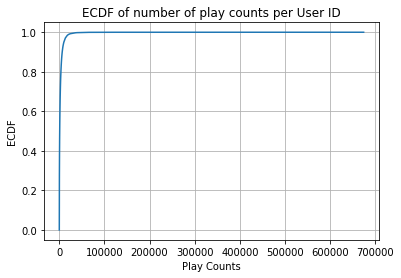

In [8]:

pdf = pd.DataFrame(data=userActivity)
Y=np.sort( pdf[1] )
yvals=np.arange(len(Y))/float(len(Y))
plt.plot( Y, yvals )
plt.xlabel('Play Counts')
plt.ylabel('ECDF')
plt.grid(True,which="both",ls="-")
plt.title('ECDF of number of play counts per User ID')
plt.show()


<div class="alert alert-warning">From this chart, it is really hard to get some insight from this curve. It would be better if we plot number of play counts in log10 scale.</div>

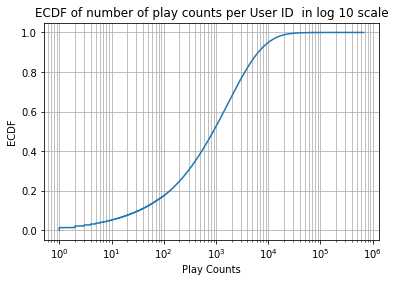

In [9]:
plt.semilogx( Y, yvals )
plt.xlabel('Play Counts')
plt.ylabel('ECDF')
plt.grid(True,which="both",ls="-")
plt.title('ECDF of number of play counts per User ID  in log 10 scale')
plt.show()

In [10]:
# Propotion of outliers in dataset.
print("Propotion of outliers with less than 10 play count: ",np.round((np.sum((Y<10)*1)/len(Y)*100),2), "%" )
print("Propotion of outliers with more than 10.000 play count: ",np.round((np.sum((Y>10000)*1)/len(Y)*100),2), "%" )

Propotion of outliers with less than 10 play count:  4.91 %
Propotion of outliers with more than 10.000 play count:  5.11 %


<div class="alert alert-warning">
<b>COMMENT:</b> Clearlly that with this log10 scale plot, we have more knowledge of the distribution of number of play count.
<ul>
<li>From the ECDF log10 scale, we can see that 25% users that have play counts less than 200 (10^2.25), 50% user that have play counts less than 1000, 95% users that have number of play counts less than 10000. .The majority of users population that have play counts from 200 to 10000. 25% of users that have play countes less than 200 and olny 5% users that have number of play counts more than 10000.</li>
<li>The more often the user is using our system (large number of play count), the more information about this user's favorite music we gather. Thus, our recommendation model will suggest the more accurate artist that they will like and vice versa, for user that didn't often use our music system, our recommendation model is likely to be less accurate.</li>
<li>In this situation, we have two kind of outliers. First case is users with very small number of play count (maybe less than 10 play counts - which is around 5% of users population). In this case, our recommendation model will not effective in recommend artist for them, but they will not affect our model either. The second case is users with a very large number of playcount (greater than 10000 play counts -which is around 5% of users population). In this case, the will affect a lot our recommendation model. However, whether this effect is positive or negative, we are not clear right now. We will try to train model with and without these outliers and compare the results.</li>
</ul>
</div>

#### Question 2.3

<div class="alert alert-info">
How many play counts for each artist? Plot CDF or ECDF of the result.  

Similarly to the previous question, you need to comment and interpret your result: what is the figure telling you?
</div>

In [11]:

# Compute artist popularity
# We are interested in how many playcounts per artist
# ATTENTION! Grouping by artistID may be problematic, as stated above.

artistPopularity = userArtistDF.groupby('artistID').sum('playCount').collect()


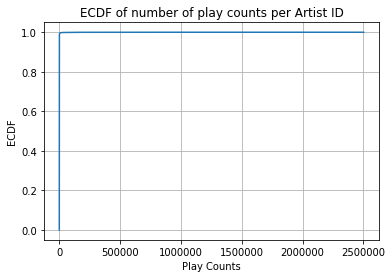

In [12]:

pdf = pd.DataFrame(data=artistPopularity)
Y=np.sort( pdf[1] )
yvals=np.arange(len(Y))/float(len(Y))

plt.plot( Y, yvals )
plt.xlabel('Play Counts')
plt.ylabel('ECDF')
plt.grid(True,which="both",ls="-")
plt.title('ECDF of number of play counts per Artist ID')
plt.show()

<div class="alert alert-warning">Ploting directly number of play counts will make us hard to see the ECDF of number of play counts. It would be better if we plot number of play counts in log10 scale</div>

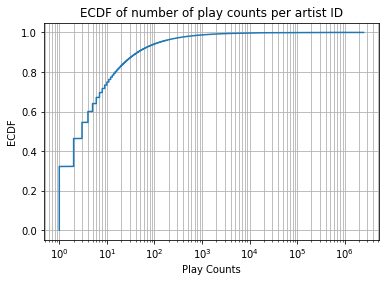

In [13]:
plt.semilogx( Y, yvals )

plt.xlabel('Play Counts')

plt.ylabel('ECDF')
plt.grid(True,which="both",ls="-")
plt.title('ECDF of number of play counts per artist ID')
plt.show()

<div class="alert alert-warning"><b>COMMENT:</b>
<ul>
<li>More than 30% of artist population have 1 play count, around 75% of artist population have less than 10 play count and only more than 5% artists that have number of play count is greater than 100. </li>
<li>We can consider number of play count is a ratio indicating the level of well known of artist. The more number of play count they have, the more frequent that they were listen by users and the more chance that we will recommend them for other users.</li>
</ul> </div>

#### Question 2.4
<div class="alert alert-info">
Plot a bar chart to show top 5 artists In terms of absolute play counts.  

Comment the figure you just obtained: 
<ul>
<li>are these reasonable results?</li>
<li>is looking at top-5 artists enough to learn more about your data?</li>
<li>do you see anything strange in the data?</li>
</ul>
</div>

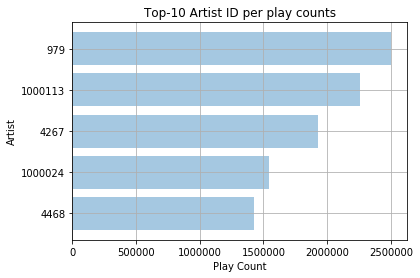

In [14]:
sortedArtist = sorted(artistPopularity, key = lambda x: -x[1])[: 5]

artistID = [w[0] for w in sortedArtist]

y_pos = range(len(sortedArtist))
frequency = [w[1] for w in sortedArtist]

plt.barh(y_pos, frequency[::-1], align='center', alpha=0.4)
plt.yticks(y_pos, artistID[::-1])
plt.xlabel('Play Count')
plt.ylabel('Artist')
plt.grid(True,which="both",ls="-")
plt.title('Top-10 Artist ID per play counts')
plt.show()

<div class="alert alert-warning"><b>COMMENT:</b>
<ul>
<li>This result is consistent with the plot we have just showed above. The maximum number of play count is more than 1.000.000. However, looking at top 5 artist will not give us usefull information about our dataset.</li>
<li>It seems like a little small proportion of artists in our dataset have a very large proportion of number of playcount. Ploting distribution of cummulative proportion of play counts by proportion of artist will give more information </li>
</ul> </div>

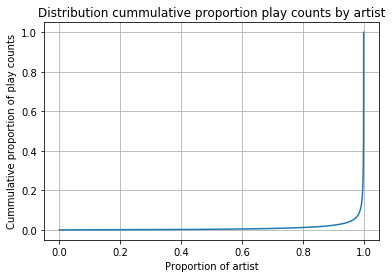

In [15]:
normArray = Y/np.sum(Y) #Calculating proportion of play counts
cumsumArray = np.cumsum(normArray) # Cummulative proportion

plt.plot( yvals,cumsumArray )

plt.ylabel('Cummulative proportion of play counts')

plt.xlabel('Proportion of artist')
plt.grid(True,which="both",ls="-")
plt.title('Distribution cummulative proportion play counts by artist')
plt.show()

<div class="alert alert-warning">
Only 5% of artists that control more than 90% of number of play counts.
</div>

In [16]:
#number of top artists by playcount (>100 playcounts)
numTopArtist = np.sum((Y>100)*1)
#total number of play count belong to top artists
numTopArtPlaycoung = np.sum(Y[Y>100])
print("Propotion of artists with more than 100 play count - top artists: ",np.round((numTopArtist/len(Y)*100),2), "%" )
print("Propotion of number of play count that belong to top-artists: ",np.round((numTopArtPlaycoung/np.sum(Y)*100),2), "%" )

Propotion of artists with more than 100 play count - top artists:  5.83 %
Propotion of number of play count that belong to top-artists:  96.43 %


<div class="alert alert-warning"><b>COMMENT:</b>
<ul>
<li>95% of artists population have less than 100 playcount and 5% of artists population have above 100 playcounts, let call them top artists. The top artists (only 5% of artists population) control more than 96% of play count's market. The other artists (95% of artists population) share only 5% of playcounts number</li>
<li>This is a strange insight in our dataset. However, it is reasonable. When an artist is listened by many people, they will have more chance to be recommended by those people who listened their songs, and the more they are recommended, the more people will continue to listen to them, and the more number of play count they will get. That will make their number of play count increasing a lot day by day.</li>
</ul> </div>

All seems clear right now, but ... wait a second! What about the problems indicated above about artist "disambiguation"? Are these artist ID we are using referring to unique artists? How can we make sure that such "opaque" identifiers point to different bands? Let's try to use some additional dataset to answer this question:  `artist_data.txt` dataset. This time, the schema of the dataset consists in:

```
artist ID: long int
name: string
```

We will try to find whether a single artist has two different IDs.

### Question 3

#### Question 3.1

<div class="alert alert-info">
Load the data from `/datasets/lastfm/artist_data.txt` and use the SparkSQL API to show 5 samples.  

<ul></ul>
<div class="label label-success">HINT:</div> If you encounter some error when parsing lines in data because of invalid entries, parameter `mode='DROPMALFORMED'` will help you to eliminate these entries. The suggested syntax is: `<df>.options(header='false', delimiter='\t', mode='DROPMALFORMED')`.

</div>

In [17]:
customSchemaArtist = StructType([ \
    StructField("artistID", LongType(), True), \
    StructField("name", StringType(), True)])

artistDF = sqlContext.read\
    .format('com.databricks.spark.csv') \
    .options(header='false', delimiter='\t', mode='DROPMALFORMED') \
    .load(base + 'artist_data.txt', schema = customSchemaArtist) \
    .cache()
    
artistDF.show(5)

+--------+--------------------+
|artistID|                name|
+--------+--------------------+
| 1134999|        06Crazy Life|
| 6821360|        Pang Nakarin|
|10113088|Terfel, Bartoli- ...|
|10151459| The Flaming Sidebur|
| 6826647|   Bodenstandig 3000|
+--------+--------------------+
only showing top 5 rows



#### Question 3.2
<div class="alert alert-info">
Find 20 artists whose name contains `Aerosmith`. Take a look at artists that have ID equal to `1000010` and `2082323`. In your opinion, are they pointing to the same artist?  

<ul></ul>
<div class="label label-success">HINT:</div> Function `locate(sub_string, string)` can be useful in this case.
</div>

In [18]:
# get artists whose name contains "Aerosmith"
artistDF[locate("Aerosmith", "name") > 0].show(20)

# show two examples
artistDF[artistDF.artistID==1000010].show()
artistDF[artistDF.artistID==2082323].show()

+--------+--------------------+
|artistID|                name|
+--------+--------------------+
|10586006|Dusty Springfield...|
| 6946007|    Aerosmith/RunDMC|
|10475683|Aerosmith: Just P...|
| 1083031|    Aerosmith/ G n R|
| 6872848|Britney, Nsync, N...|
|10586963|Green Day - Oasis...|
|10028830|The Aerosmith Ant...|
|10300357| Run-DMC + Aerosmith|
| 2027746|Aerosmith by Musi...|
| 1140418|[rap]Run DMC and ...|
|10237208| Aerosmith + Run DMC|
|10588537|Aerosmith, Kid Ro...|
| 9934757|Aerosmith - Big Ones|
|10437510|Green Day ft. Oas...|
| 6936680| RUN DNC & Aerosmith|
|10479781|      Aerosmith Hits|
|10114147|Charlies Angels -...|
| 1262439|Kid Rock, Run DMC...|
| 7032554|Aerosmith & Run-D...|
|10033592|          Aerosmith?|
+--------+--------------------+
only showing top 20 rows

+--------+---------+
|artistID|     name|
+--------+---------+
| 1000010|Aerosmith|
+--------+---------+

+--------+------------+
|artistID|        name|
+--------+------------+
| 2082323|01 Aerosmith|
+---

<div class="alert alert-warning"><b>COMMENT:</b>
<ul>
<li>The name "Aerosmith" and "01 Aerosmith" are clearly variation of the same artist "Aerosmith" with different artistID. Furthermore, we can see from the list of 20 artists that contains "Aerosmith" above, "Aerosmish?" and "Aerosmith Hits" are also variation of "Aerosmith" and only him. There are couple of reasons that create this variation. For example, "Aerosmith?" maybe due to spelling mistake; "Aerosmith Hits" came from mistake in taking playlist name instead of artist name; "01 Aerosmith" maybe created by the first song in album of Aerosmith</li>
<li>Some name of artist in our dataset is actually a band of artists. For this band of artists, there are serveral approaches, ones could be separating those band of artists to separetly artists. For example, user A, play song of Aerosmith/ GnR for 5 times, we can separate this data to user A play Aerosmith for 5 time, and play GnR for 5 time. However, it might be the case, that user A is only like listening to the combination of Aerosmith and GnR, then keeping Aerosmith/ GnR might be better. For this scope of this labolatory, we will keep the band of artists as a artist.</li>
</ul> </div>

To answer this question correctly, we need to use an additional dataset `artist_alias.txt` which contains the ids of mispelled artists and standard artists. The schema of the dataset consists in:

```
mispelledID ID: long int
standard ID: long int
```

#### Question 3.3
<div class="alert alert-info">
Using SparkSQL API, load the dataset from `/datasets/lastfm/artist_alias.txt` then show 5 samples.
</div>

In [19]:
customSchemaArtistAlias = StructType([ \
    StructField('mispelledID',LongType(), True ), \
    StructField('standard',LongType(), True )])

artistAliasDF = sqlContext.read \
    .format('com.databricks.spark.csv') \
    .options(header='false',delimiter='\t', mode='DROPMALFORMED') \
    .load(base + 'artist_alias.txt', schema = customSchemaArtistAlias) \
    .cache()

artistAliasDF.show(5)

+-----------+--------+
|mispelledID|standard|
+-----------+--------+
|    1092764| 1000311|
|    1095122| 1000557|
|    6708070| 1007267|
|   10088054| 1042317|
|    1195917| 1042317|
+-----------+--------+
only showing top 5 rows



#### Question 3.4
<div class="alert alert-info">
Verify the answer of question 3.2 ("Are artists that have ID equal to `1000010` and `2082323` the same ?") by finding the standard ids corresponding to the mispelled ids `1000010` and `2082323` respectively.
</div>

In [20]:
artistAliasDF[artistAliasDF.mispelledID==1000010].show()
artistAliasDF[artistAliasDF.mispelledID==2082323 ].show()

# 1000010 is a standard id, so it haven't been considered as mispelled id in the dataset

+-----------+--------+
|mispelledID|standard|
+-----------+--------+
+-----------+--------+

+-----------+--------+
|mispelledID|standard|
+-----------+--------+
|    2082323| 1000010|
+-----------+--------+



### Question 4

The mispelled or nonstandard information about artist make our results in the previous queries a bit "sloppy". To overcome this problem, we can replace all mispelled artist ids by the corresponding standard ids and re-compute the basic descriptive statistics on the "amended" data.
First, we construct a "dictionary" that maps non-standard ids to a standard ones. Then this "dictionary" will be used to replace the mispelled artists.

#### Question 4.1
<div class="alert alert-info">
From data in the dataframe loaded from `/datasets/lastfm/artist_alias.txt`, construct a dictionary that maps each non-standard id to its standard id.  

<div class="label label-success">HINT:</div> Instead of using function `collect`, we can use `collectAsMap` to convert the collected data to a dictionary inline.
</div>

In [21]:
artistAlias = artistAliasDF.rdd.map(lambda row: ( row['mispelledID'] , row['standard'])).collectAsMap()

#### Question 4.2
<div class="alert alert-info">
Using the constructed dictionary in question 4.1, replace the non-standard artist ids in the dataframe that was loaded from `/datasets/lastfm/user_artist_data.txt` by the corresponding standard ids then show 5 samples.
</div>


**NOTE 1**: If an id doesn't exist in the dictionary as a mispelled id, it is really a standard id.


Using funtion `map` on Spark Dataframe will give us an RDD. We can convert this RDD back to Dataframe by using `sqlContext.createDataFrame(rdd_name, sql_schema)`


**NOTE 2**: be careful! you need to be able to verify that you indeed solved the problem of having bad artist IDs. In principle, for the new data to be correct, we should to have duplicate pairs (user, artist), potentially with different play counts, right? In answering the question, please **show** that you indeed fixed the problem. 

In [22]:
artistAliasDF.show(10)

+-----------+--------+
|mispelledID|standard|
+-----------+--------+
|    1092764| 1000311|
|    1095122| 1000557|
|    6708070| 1007267|
|   10088054| 1042317|
|    1195917| 1042317|
|    1112006| 1000557|
|    1187350| 1294511|
|    1116694| 1327092|
|    6793225| 1042317|
|    1079959| 1000557|
+-----------+--------+
only showing top 10 rows



In [23]:
from time import time

def replaceMispelledIDs(fields):
    finalID = artistAlias.get(fields[1], fields[1])
    return (fields[0], finalID, fields[2])

t0 = time()

newUserArtistDF = sqlContext.createDataFrame(
    userArtistDF.rdd.map(lambda row: replaceMispelledIDs(row)), 
    userArtistDataSchema
)
newUserArtistDF.show(5)

t1 = time()

print('The script takes %f seconds' %(t1-t0))

+-------+--------+---------+
| userID|artistID|playCount|
+-------+--------+---------+
|1000002|       1|       55|
|1000002| 1000006|       33|
|1000002| 1000007|        8|
|1000002| 1000009|      144|
|1000002| 1000010|      314|
+-------+--------+---------+
only showing top 5 rows

The script takes 1.732657 seconds


<div class="alert alert-warning"><b>COMMENT:</b>
<ul>
<li>To verify that we have already fixed mispelling name from above code, we will count number of distinct records of (userID, artistID) in our dataset. If this number less that number of rows in our original dataset, we success in replacing the mispelling artist name to standard name.</li>
</ul> </div>

In [24]:
NoDuplicateUserArtistDF = newUserArtistDF.groupBy('userID','artistID') \
    .agg({'playCount':'sum'}).withColumnRenamed('sum(playCount)', 'playCount') \
    .cache()

In [25]:
print("Number of distinct (UserID,ArtistID) in origin dataset:",userArtistDF.count())
print("Number of distinct (UserID,ArtistID) in standard dataset:",NoDuplicateUserArtistDF.count())

Number of distinct (UserID,ArtistID) in origin dataset: 24296858
Number of distinct (UserID,ArtistID) in standard dataset: 24133304


<div class="alert alert-warning"> Number of (userID,artistID) in our new standard dataset is less than number of (userID, artistID) in our original dataset. That means some of (userID, artistID) in original ones were replaced by standard ones, sum play count number to play count number of standard ones/
</div>

#### Question 4.3
<div class="alert alert-info">
Spark actions are executed through a set of stages, separated by distributed "shuffle" operations. Spark can be instructed to **automatically and efficiently** broadcast common data needed by tasks within **each stage**. The data broadcasted this way is cached in **serialized form** and deserialized before running each task.   
<ul> </ul>
We can thus improve our answer to question 4.2: we can reduce the communication cost by shipping the "dictionary" in a more efficient way by using `broadcast variable`. Broadcast variables allow the programmer to keep a read-only variable cached on **each machine** rather than shipping a copy of it with tasks. They are cached in deserialized form. They can be used, for example, to give every node a copy of a large input dataset in an efficient manner.   
<ul></ul>
The broadcast of variable `v` can be created by `bV = sc.broadcast(v)`. Then value of this broadcast variable can be access via `bV.value`  

<ul></ul>
To question is then: using a broadcast variable, modify the script in question 4.2 to get better performance in terms of running time.
</div>


In [26]:
from time import time

bArtistAlias = sc.broadcast(artistAlias)

def replaceMispelledIDs(fields):
    finalID = bArtistAlias.value.get(fields[1] , fields[1])
    return (fields[0] , finalID, fields[2])

t0 = time()

newUserArtistDF = sqlContext.createDataFrame(
    userArtistDF.rdd.map(replaceMispelledIDs), 
    userArtistDataSchema
)
newUserArtistDF.show(5)
t1 = time()

print('The script takes %f seconds' %(t1-t0))
newUserArtistDF = newUserArtistDF.cache()

+-------+--------+---------+
| userID|artistID|playCount|
+-------+--------+---------+
|1000002|       1|       55|
|1000002| 1000006|       33|
|1000002| 1000007|        8|
|1000002| 1000009|      144|
|1000002| 1000010|      314|
+-------+--------+---------+
only showing top 5 rows

The script takes 0.208056 seconds


<div class="alert alert-warning"><b>COMMENT:</b>
<ul>
<li>Here the fact of using a broadcast variable give us an execution time  3.66 faster than the first approach.</li>

</ul> </div>

Although having some advantages, explicitly creating broadcast variables is only useful when tasks across multiple stages need the same data or when caching the data in deserialized form is important.

### Question 5

Well, our data frame contains clean and "standard" data. We can use it to redo previous statistic queries.

#### Question 5.1
<div class="alert alert-info">
How many unique artists? Compare with the result when using old data.
</div>

In [27]:
uniqueArtists = newUserArtistDF.select('artistID').distinct().count()

print("Total n. of artists: ", uniqueArtists)

Total n. of artists:  1568126


<div class="alert alert-warning"><b>Comparison:</b>
<ul>
<li>In the old data we had **1,631,028** unique artists, while in this new "post-correction" data we have **1,568,126** unique artists. </li>
<li>Then in the orginal data we had **62902** copies of already existing artists that were initially tought of as completly distinct artists due to the mistake of mispelling</li>
</ul> </div>

#### Question 5.2

<div class="alert alert-info">
Who are the top-10 artistis?
<ul>
  <li>In terms of absolute play counts</li>
  <li>In terms of "audience size", that is, how many users listened to one of their track at least once</li>
</ul>  

Plot the results, and explain the figures you obtain.
</div>

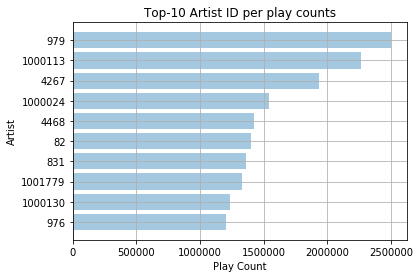

In [28]:
# calculate top-10 artists in term of play counts
# NoDuplicateUserArtistDF is dataframe which was created from by newUserArtistDF by summing up playcount of all rows
# have the same (userID, artistID) - calculated above
top10ArtistsPC = NoDuplicateUserArtistDF.groupBy('artistID') \
    .sum('playCount') \
    .orderBy('sum(playCount)', ascending=0).take(10)

y_pos = range(len(top10ArtistsPC))
pdf = pd.DataFrame(data=top10ArtistsPC)

plt.barh(y_pos, pdf[1][::-1], align='center', alpha=0.4)
plt.yticks(y_pos, pdf[0][::-1])
plt.xlabel('Play Count')
plt.ylabel('Artist')
plt.grid(True,which="both",ls="-")
plt.title('Top-10 Artist ID per play counts')
plt.show()


<div class="alert alert-warning">
For human understanding aspect, it will better to display artists by their name than their ID</div>

In [29]:
artistNameDict=artistDF.rdd.collectAsMap()
def artistId2Name(artistID):
    return artistNameDict.get(artistID,"")

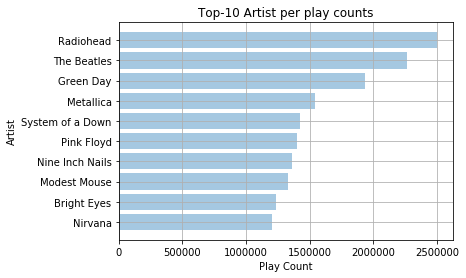

In [30]:
plt.barh(y_pos, pdf[1][::-1], align='center', alpha=0.4)
ylabel = [artistId2Name(x) for x in pdf[0][::-1]]
plt.yticks(y_pos, ylabel)
plt.xlabel('Play Count')
plt.ylabel('Artist')
plt.grid(True,which="both",ls="-")
plt.title('Top-10 Artist per play counts')
plt.show()

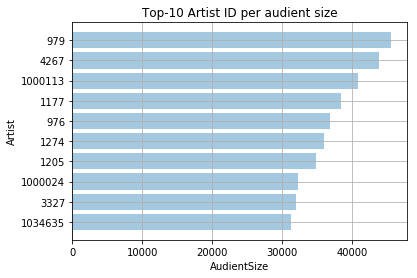

In [31]:
# calculate top-10 artists in term of audience size
# NoDuplicateUserArtistDF is dataframe which was created from by newUserArtistDF by summing up playcount of all rows
# have the same (userID, artistID) - calculated above
top10ArtistsPC = NoDuplicateUserArtistDF.groupBy('artistID').count().orderBy('count', ascending=0).take(10)

y_pos = range(len(top10ArtistsPC))
pdf = pd.DataFrame(data=top10ArtistsPC)

plt.barh(y_pos, pdf[1][::-1], align='center', alpha=0.4)
plt.yticks(y_pos, pdf[0][::-1])
plt.xlabel('AudientSize')
plt.ylabel('Artist')
plt.grid(True,which="both",ls="-")
plt.title('Top-10 Artist ID per audient size')
plt.show()

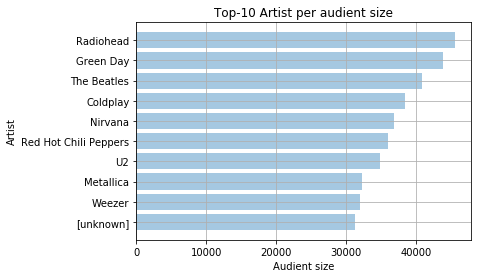

In [32]:
plt.barh(y_pos, pdf[1][::-1], align='center', alpha=0.4)
ylabel = [artistId2Name(x) for x in pdf[0][::-1]]
plt.yticks(y_pos, ylabel)
plt.xlabel('Audient size')
plt.ylabel('Artist')
plt.grid(True,which="both",ls="-")
plt.title('Top-10 Artist per audient size')
plt.show()

<div class="alert alert-warning">
<b>COMMENT:</b> 
<ul>
<li>The artist who has the highest number of play count does not mean that he/she also has the highest number of audients. However, two above charts are still consistent in top-artist position. We can see that the positions of top 3 artists by play count (Raidohead, Green Day, The Beatles) and top 3 artists by audient size are the same (4th position by play count (Metallica) is still in top 10 artist by audient size.)</li>
<li>The diffenrence in comparative position in ranking by number of playcount and by audient size can give us information of loyalty of audient. The artist, who has high position in ranking by number of playcount but low rank by number of audient, has audients with high loyalty (each his/her audients play his/her songs a lot). Thus, it will be more accurate when we recommend songs of those artists to users who are similar to their audients.</li>
<li>In this list, we see there is a strange artist: [unknown]. [unknown] is a name that stand for missing information in our system. [unknown] can be any artist, so it could affect to our model. It could be better if we discard all the data related to [unknown] artist. </li>
<li>There might be many way to display unknown artist in our dataset. We will check them by check all the artist name contain 'unknown', and the popular of this 'unknown' by check the number of play Count of this 'unknown' </li>
</ul>
</div>

In [33]:
#First, we will group by 'artistID' and sum play count, then join with artistDF to get name of each artistID
UserArtistNameDF = NoDuplicateUserArtistDF.groupBy('artistID').sum('playCount').join(artistDF, on="artistID")
unknownArtistUserNameDF = UserArtistNameDF[locate("unknown", "name") > 0].orderBy('sum(playCount)', ascending=0).show(20)

+--------+--------------+--------------------+
|artistID|sum(playCount)|                name|
+--------+--------------+--------------------+
| 1034635|        429447|           [unknown]|
| 1022938|          2094|         pop unknown|
| 1066090|           233|     DJ unknown face|
| 6855266|           216|         ZZZ unknown|
| 2118147|            60|unknown album (d0...|
| 6867780|            43|Peter Clarke(arra...|
| 6725106|            34|unknown (cover ve...|
| 6648230|            31|     several unknown|
| 1090855|            29|         Kid unknown|
| 2280087|            27|"colored quartet"...|
| 6827178|            27|hyperunknown & co...|
|10391248|            24|Tego Calderon FT....|
| 2091916|            22|        hyperunknown|
| 6866171|            21|      bjork, unknown|
|10551757|            18|Team Sleep - unknown|
|10259532|            18| a cappella, unknown|
| 1142871|            18|      source unknown|
|10750824|            17|   unknown eskimo DJ|
| 2099080|   

<div class="alert alert-warning">
<b>COMMENT:</b> 
<ul>
<li>We can see that [unknown] 'artist' with ID 1034635 has a hugh number of play count. We should discard this artist out of our dataset before training.</li>
</ul>
</div>

#### Question 5.3

<div class="alert alert-info">
Who are the top-10 users?
<ul>
  <li>In terms of absolute play counts</li>
  <li>In terms of "curiosity", that is, how many different artists they listened to</li>

</ul>  

Plot the results
</div>

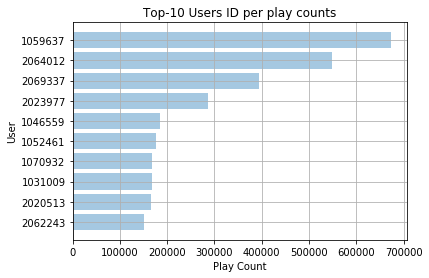

In [34]:
# calculate top 10 users interm of play counts
# NoDuplicateUserArtistDF is dataframe which was created from by newUserArtistDF by summing up playcount of all rows
# have the same (userID, artistID) - calculated above
top10UsersByPlayCount = NoDuplicateUserArtistDF.groupby('userID') \
    .sum('playCount') \
    .orderBy('sum(playCount)',ascending=0).take(10)

y_pos = range(len(top10UsersByPlayCount))
pdf = pd.DataFrame(data=top10UsersByPlayCount)

plt.barh(y_pos, pdf[1][::-1], align='center', alpha=0.4)
plt.yticks(y_pos, pdf[0][::-1])
plt.xlabel('Play Count')
plt.ylabel('User')
plt.grid(True,which="both",ls="-")
plt.title('Top-10 Users ID per play counts')
plt.show()

In [35]:
# NoDuplicateUserArtistDF is dataframe which was created from by newUserArtistDF by summing up playcount of all rows
# have the same (userID, artistID) - calculated above
top10UsersByCuriosity = NoDuplicateUserArtistDF.groupby('userID') \
    .count() \
    .orderBy('count',ascending=0) \
    .take(10) \
    

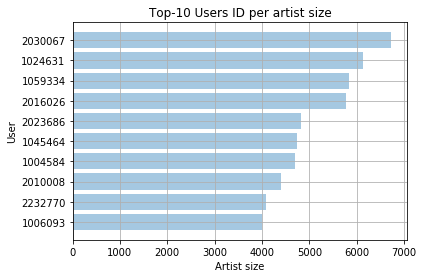

In [36]:
y_pos = range(len(top10UsersByCuriosity))
pdf = pd.DataFrame(data=top10UsersByCuriosity)

plt.barh(y_pos, pdf[1][::-1], align='center', alpha=0.4)
plt.yticks(y_pos, pdf[0][::-1])
plt.xlabel('Artist size')
plt.ylabel('User')
plt.grid(True,which="both",ls="-")
plt.title('Top-10 Users ID per artist size')
plt.show()

<div class="alert alert-warning">
<b>COMMENT:</b> 
<ul>
<li>From the chart of top-user by play count, we can see that there is a hugh difference between the top 4 users and the rest. We are doubting that those are real users, we think that they are very likely to be a due to bots, or some songs playing in the backround and within a loop. The top 4 user have a really large amound of play count, which is really strange and we should treat them as outlier.</li>
<li>Not like the charts of top artist by play count and by audient size, userIDs in top users by play count and by artist size are totally different. This fact leads to the idea of normalizing number of play count before training model. This approach will be discussed later in training model part. </li>
</ul>
</div>

In [37]:
outliersID = pd.DataFrame(data=top10UsersByPlayCount)[0][:4]
def NotOutlier(userID):
    if userID in outliersID.tolist():
        return False
    else:
        return True

Now we have some valuable information about the data. It's the time to study how to build a statistical models.

# 2. Build a statistical models to make recommendations

## 2.1 Introduction to recommender systems

In a recommendation-system application there are two classes of entities, which we shall refer to as `users` and `items`. Users have preferences for certain items, and these preferences must be inferred from the data. The data itself is represented as a `preference matrix` $A$, giving for each user-item pair, a value that represents what is known about the degree of preference of that user for that item. The table below is an example for a `preference matrix` of 5 users and `k` items. The `preference matrix` is also known as `utility matrix`.

| | IT1 | IT2 | IT3 | ... | ITk |
|---|---|---|---|---|---|
| U1 | 1 |  | 5 | ... | 3 |
| U2 |  | 2 |  | ... | 2 |
| U3 | 5 |  | 3 | ... |  |
| U4 | 3 | 3 |  | ... | 4 |
| U5 |  | 1 |  | ... | ... |

The value of row i, column j expresses how much does user `i` like item `j`. The values are often the rating scores of users for items. An unknown value implies that we have no explicit information about the user's preference for the item. The goal of a recommendation system is to predict "the blanks" in the `preference matrix`. For example, assume that the rating score is from 1 (dislike) to 5 (love), would user `U5` like `IT3` ? We have two approaches:

* Designing our recommendation system to take into account properties of items such as brand, category, price... or even the similarity of their names. We can denote the similarity of items `IT2` and `IT3`, and then conclude that because user `U5` did not like `IT2`, they were unlikely to enjoy SW2 either.

* We might observe that the people who rated both `IT2` and `IT3` tended to give them similar ratings. Thus, we could conclude that user `U5` would also give `IT3` a low rating, similar to `U5`'s rating of `IT2`

It is not necessary to predict every blank entry in a `utility matrix`. Rather, it is only necessary to discover some entries in each row that are likely to be high. In most applications, the recommendation system does not oﬀer users a ranking of all items, but rather suggests a few that the user should value highly. It may not even be necessary to ﬁnd all items with the highest expected ratings, but only to ﬁnd a large subset of those with the highest ratings.


## 2.2 Families of recommender systems

In general, recommender systems can be categorized into two groups:

* **Content-Based** systems focus on properties of items. Similarity of items is determined by measuring the similarity in their properties.

* **Collaborative-Filtering** systems focus on the relationship between users and items. Similarity of items is determined by the similarity of the ratings of those items by the users who have rated both items.

In the usecase of this notebook, artists take the role of `items`, and `users` keep the same role as `users`.
Since we have no information about `artists`, except their names, we cannot build a `content-based` recommender system.

Therefore, in the rest of this notebook, we only focus on `Collaborative-Filtering` algorithms.

## 2.3 Collaborative-Filtering 
In this section, we study a member of a broad class of algorithms called `latent-factor` models. They try to explain observed interactions between large numbers of users and products through a relatively small number of unobserved, underlying reasons. It is analogous to explaining why millions of people buy a particular few of thousands of possible albums by describing users and albums in terms of tastes for perhaps tens of genres, tastes which are **not directly observable or given** as data. 

First, we formulate the learning problem as a matrix completion problem. Then, we will use a type of `matrix factorization` model to "fill in" the blanks.  We are given implicit ratings that users have given certain items (that is, the number of times they played a particular artist) and our goal is to predict their ratings for the rest of the items. Formally, if there are $n$ users and $m$ items, we are given an $n \times m$ matrix $R$ in which the generic entry $(u, i)$ represents the rating for item $i$ by user $u$. **Matrix $R$ has many missing entries indicating unobserved ratings, and our task is to estimate these unobserved ratings**.

A popular approach to the matrix completion problem is **matrix factorization**, where we want to "summarize" users and items with their **latent factors**.

### 2.3.1 Basic idea and an example of Matrix Factorization
For example, given a preference matrix 5x5 as below, we want to approximate this matrix into the product of two smaller matrixes $X$ and $Y$ .

$$
M = 
\begin{bmatrix}
 5 & 2 & 4 & 4 & 3 \\
 3 & 1 & 2 & 4 & 1 \\
 2 &  & 3 & 1 & 4 \\
 2 & 5 & 4 & 3 & 5 \\
 4 & 4 & 5 & 4 &  \\
\end{bmatrix}
\approx M^\prime =
\begin{bmatrix}
 x_{11} & x_{12} \\
 x_{21} & x_{22} \\
 x_{31} & x_{32} \\
 x_{41} & x_{42} \\
 x_{51} & x_{52} \\
\end{bmatrix}
\times
\begin{bmatrix}
 y_{11} & y_{12} & y_{13} & y_{14} & y_{15} \\
 y_{21} & y_{22} & y_{23} & y_{24} & y_{25} \\
\end{bmatrix}
$$

$M^\prime$ is an approximation that is as close to A as possible. To calculate how far from $M$ $M^\prime$ is, we often calculate the sum of squared distances of non-empty elements in $M$ and the corresponding elements in $M^\prime$.
In this way, for $M^\prime$, besides the approximated elements in $M$, we also have the non-observed elements. Therefore, to see how much does user `i` like item `j`, we simply pick up the value of $M^\prime_{i,j}$.

The challenge is how to calculate $X$ and $Y$. The bad news is that this can't be solved directly for both the best $X$ and best $Y$ at the same time. Fortunately, if $Y$ is known, we can calculate the best of $X$, and vice versa. It means from the initial values of $X$ and $Y$ in the beginning, we calculate the best $X$ according to $Y$, and then calculate the best $Y$ according to the new $X$. This process is repeated until the distance from $XY$ to $M$ is small. It's simple, right ?

Let's take an example. To compute the approximation for the above 5x5 matrix $M$, first, we initialize the value of $X$ and $Y$ as below.

$$
M^\prime = X \times Y =
\begin{bmatrix}
 1 & 1 \\
 1 & 1 \\
 1 & 1 \\
 1 & 1 \\
 1 & 1 \\
\end{bmatrix}
\times
\begin{bmatrix}
 1 & 1 & 1 & 1 & 1 \\
 1 & 1 & 1 & 1 & 1 \\
\end{bmatrix}
=
\begin{bmatrix}
 2 & 2 & 2 & 2 & 2 \\
 2 & 2 & 2 & 2 & 2 \\
 2 & 2 & 2 & 2 & 2 \\
 2 & 2 & 2 & 2 & 2 \\
 2 & 2 & 2 & 2 & 2 \\
\end{bmatrix}
$$

With the initial iteration, we calculate the the Root-Mean-Square Error from $XY$ to $M$.

Consider the ﬁrst rows of $M$ and $XY$ . We subtract the first row of $XY$ from the entries in the ﬁrst row of $M$, to get $3,0,2,2,1$. We square and sum these to get $18$. 

In the second row, we do the same to get $1,−1,0,2,−1$, square and sum to get $7$. 

In the third row, the second column is blank, so that entry is ignored when computing the RMSE. The diﬀerences are $0,1,−1,2$ and the sum of squares is $6$. 

For the fourth row, the diﬀerences are $0,3,2,1,3$ and the sum of squares is $23$. 

The ﬁfth row has a blank entry in the last column, so the diﬀerences are $2,2,3,2$ and the sum of squares is $21$. 

When we sum the sums from each of the ﬁve rows, we get $18+7+6+23+21 = 75$. So, $RMSE=\sqrt{75/23}=1.806$ where $23$ is the number of non-empty values in $M$.

Next, with the given value of $Y$, we calculate $X$ by finding the best value for $X_{11}$.

$$
M^\prime = X \times Y =
\begin{bmatrix}
 x & 1 \\
 1 & 1 \\
 1 & 1 \\
 1 & 1 \\
 1 & 1 \\
\end{bmatrix}
\times
\begin{bmatrix}
 1 & 1 & 1 & 1 & 1 \\
 1 & 1 & 1 & 1 & 1 \\
\end{bmatrix}
=
\begin{bmatrix}
 x+1 & x+1 & x+1 & x+1 & x+1 \\
 2 & 2 & 2 & 2 & 2 \\
 2 & 2 & 2 & 2 & 2 \\
 2 & 2 & 2 & 2 & 2 \\
 2 & 2 & 2 & 2 & 2 \\
\end{bmatrix}
$$

Now, to minimize the $RMSE$  we minimize the difference of the first rows $(5−(x+1))^2 + (2−(x+1))^2 + (4−(x+1))^2 + (4−(x+1))^2 + (3−(x+1))^2$. By  taking the derivative and set that equal to 0, we pick $x=2.6$

Given the new value of $X$, we can calculate the best value for $Y$.

$$
M^\prime = X \times Y =
\begin{bmatrix}
 2.6 & 1 \\
 1 & 1 \\
 1 & 1 \\
 1 & 1 \\
 1 & 1 \\
\end{bmatrix}
\times
\begin{bmatrix}
 y & 1 & 1 & 1 & 1 \\
 1 & 1 & 1 & 1 & 1 \\
\end{bmatrix}
=
\begin{bmatrix}
 3.6 & 3.6 & 3.6 & 3.6 & 3.6 \\
 2 & 2 & 2 & 2 & 2 \\
 2 & 2 & 2 & 2 & 2 \\
 2 & 2 & 2 & 2 & 2 \\
 2 & 2 & 2 & 2 & 2 \\
\end{bmatrix}
$$

By doing the same process as before, we can pick value for $y=1.617$. After that, we can check if the $RMSE$ is not converged, we continue to update $X$ by $Y$ and vice versa. In this example, for simple, we only update one element of each matrix in each iteration. In practice, we can update a full row or full matrix at once.


### 2.3.2 Matrix Factorization: Objective and ALS Algorithm on a Single Machine

More formally, in general, we select $k$ latent features, and describe each user $u$ with a $k-$dimensional vector $x_u$, and each item $i$ with a $k-$dimensional vector $y_i$.

Then, to predict user $u$'s rating for item $i$, we do as follows: $ r_{ui} \approx x_{u}^{T}y_i$.

This can be put, more elegantly, in a matrix form. Let $x_1, \cdots x_n \in \mathbb{R}^k$ be the factors for the users, and $y_1, \cdots y_m \in \mathbb{R}^k$ the factors for the items. The $k \times n$ user matrix $X$ and the $k \times m$ item matrix $Y$ are then defined by:

$$
X = 
\begin{bmatrix}
 |   &         & |  \\
x_1  &  \cdots & x_n\\
 |   &         & |  \\
\end{bmatrix}
$$

$$
Y = 
\begin{bmatrix}
 |   &         & |  \\
y_1  &  \cdots & y_i\\
 |   &         & |  \\
\end{bmatrix}
$$

Our goal is to estimate the complete ratings matrix $R \approx X^{T} Y$. We can formulate this problem as an optimization problem in which we aim to minimize an objective function and find optimal $X$ and $Y$ . In particular, we aim to minimize the least squares error of the observed ratings (and regularize):

$$
\min_{X,Y} \sum_{r_{ui} \text{observed}}(r_{ui} - x_{u}^{T}y_i)^2 + \lambda \left( \sum_{u} \|x_u\|^2 + \sum_{i} \|y_i\|^2 \right) 
$$

Notice that this objective is non-convex (because of the $x_{u}^{T} y_i$ term); in fact it’s NP-hard to optimize. Gradient descent can be used as an approximate approach here, however it turns out to be slow and costs lots of iterations. Note however, that if we fix the set of variables $X$ and treat them as constants, then the objective is a convex function of $Y$ and vice versa. Our approach will therefore be to fix $Y$ and optimize $X$, then fix $X$ and optimize $Y$, and repeat until convergence. This approach is known as **ALS (Alternating Least Squares)**. For our objective function, the alternating least squares algorithm can be expressed with this simple pseudo-code:


**Initialize** $X$, $Y$

**while(convergence is not true) do**


**for** $u = 1 \cdots n$ **do**

$x_u = \left( \sum_{r_ui \in r_{u*}} y_i y_{i}^{T} + \lambda I_k \right)^{-1} \sum_{r_ui \in r_{u*}} r_{ui} y_i $ 
   
**end for**

**for** $u = 1 \cdots n$ **do**

$y_i = \left( \sum_{r_ui \in r_{*i}} x_u x_{u}^{T} + \lambda I_k \right)^{-1} \sum_{r_ui \in r_{*i}} r_{ui} x_u $ 
   
**end for**


**end while**


For a single machine, we can analyze the computational cost of this algorithm. Updating each $x_u$ will cost $O(n_u k^2 + k^3)$, where $n_u$ is the number of items rated by user $u$, and similarly updating each $y_i$ will cost $O(n_i k^2 + k^3)$, where $n_i$ is the number of users that have rated item $i$.


Once we’ve computed the matrices $X$ and $Y$, there are several ways compute a prediction. The first is to do what was discussed before, which is to simply predict $ r_{ui} \approx x_{u}^{T}y_i$ for each user $u$ and item $i$. 
This approach will cost $O(nmk)$ if we’d like to estimate every user-item pair. 

However, this approach is prohibitively expensive for most real-world datasets. A second (and more holistic) approach is to use the $x_u$ and $y_i$ as features in another learning algorithm, incorporating these features with others that are relevant to the prediction task.

### 2.3.3 Parallel Altenating Least Squares

There are several ways to distribute the computation of the ALS algorithm depending on how data is partitioned.

#### Method 1: using joins
First we consider a fully distributed version, in the sense that all data (both input and output) is stored in a distributed file system. In practice, input data (ratings) and parameters ($X$ and $Y$) are stored in an a Spark RDD. Specifically, ratings -- that are always **sparse** -- are stored as RDD of triplets:

Ratings: RDD((u, i, $r_{ui}$), . . . )


Instead, we can use dense representation for factor matrices $X$ and $Y$, and these are stored as RDDs of vectors. More precisely, we can use the data types introduced in Spark MLLib to store such vectors and matrices:

X : RDD($x_1$,...,$x_n$)

Y : RDD($y_1$,...,$y_m$)


Now, recall the expression to compute $x_u$:

$x_u = \left( \sum_{r_ui \in r_{u*}} y_i y_{i}^{T} + \lambda I_k \right)^{-1} \sum_{r_ui \in r_{u*}} r_{ui} y_i $ 

Let's call the first summation *part A* and the second summation *part B*. To compute such parts, in parallel, we can proceed with the following high-level pseudocode:

* Join the Ratings RDD with the $Y$ matrix RDD using key $i$ (items)
* Map to compute $y_i y_{i}^{T}$ and emit using key $u$ (user)
* ReduceByKey $u$ (user) to compute $\sum_{r_ui \in r_{u*}} y_i y_{i}^{T}$
* Invert
* Another ReduceByKey $u$ (user) to compute $\sum_{r_ui \in r_{u*}} r_{ui} y_i$

We can use the same template to copmute $y_i$.

This approach works fine, but note it requires computing $y_i y_{i}^{T}$ for each user that has rated item $i$. 

#### Method 2: using broadcast variables (advanced topic)
The next approach takes advantage of the fact that the $X$ and $Y$ factor matrices are often very small and can be stored locally on each machine.

* Partition the Ratings RDD **by user** to create $R_1$, and similarly partition the Ratings RDD **by item** to create $R_2$. This means there are two copies of the same Ratings RDD, albeit with different partitionings. In $R_1$, all ratings by the same user are on the same machine, and in $R_2$ all ratings for same item are on the same machine.
* Broadcast the matrices $X$ and $Y$. Note that these matrices are not RDD of vectors: they are now "local: matrices.
* Using $R_1$ and $Y$, we can use expression $x_u$ from above to compute the update of $x_u$ locally on each machine
* Using $R_2$ and $X$, we can use expression $y_i$ from above to compute the update of $y_i$ locally on each machine

A further optimization to this method is to group the $X$ and $Y$ factors matrices into blocks (user blocks and item blocks) and reduce the communication by only sending to each machine the block of users (or items) that are needed to compute the updates at that machine. 

This method is called **Block ALS**. It is achieved by precomputing some information about the ratings matrix to determine the "out-links" of each user (which blocks of the items it will contribute to) and "in-link" information for each item (which of the factor vectors it receives from each user block it will depend on). For exmple, assume that machine 1 is responsible for users 1,2,...,37: these will be block 1 of users. The items rated by these users are block 1 of items. Only the factors of block 1 of users and block 1 of items will be broadcasted to machine 1.

### Further readings
Other methods for matrix factorization include:

* Low Rank Approximation and Regression in Input Sparsity Time, by Kenneth L. Clarkson, David P. Woodruff. http://arxiv.org/abs/1207.6365
* Generalized Low Rank Models (GLRM), by Madeleine Udell, Corinne Horn, Reza Zadeh, Stephen Boyd. http://arxiv.org/abs/1410.0342
* Matrix Completion and Low-Rank SVD via Fast Alternating Least Squares, by Trevor Hastie, Rahul Mazumder, Jason D. Lee, Reza Zadeh . Statistics Department and ICME, Stanford University, 2014. http://stanford.edu/~rezab/papers/fastals.pdf

# 3. Usecase : Music recommender system

In this usecase, we use the data of users and artists in the previous sections to build a statistical model to recommend artists for users.
 
## 3.1 Requirements
According to the properties of data, we need to choose a recommender algorithm that is suitable for this implicit feedback data. It means that the algorithm should learn without access to user or artist attributes such as age, genre,.... Therefore, an algorithm of type `collaborative filtering` is the best choice.

Second, in the data, there are some users that have listened to only 1 artist. We need an algorithm that might provide decent recommendations to even these users. After all, at some point, every user starts out with just one play at some point! 

Third, we need an algorithm that scales, both in its ability to build large models, and to create recommendations quickly. So, an algorithm which can run on a distributed system (SPARK, Hadoop...) is very suitable.

From these requirement, we can choose using ALS algorithm in SPARK's MLLIB.

Spark MLlib’s ALS implementation draws on ideas from [1](http://yifanhu.net/PUB/cf.pdf) and [2](http://link.springer.com/chapter/10.1007%2F978-3-540-68880-8_32).

## 3.2 Notes

Currently, MLLIB can only build models from an RDD. That means we have two ways to prepare data:

* Loading to into SPARK SQL DataFrame as before, and then access the corresponding RDD by calling `<dataframe>.rdd`. The invalid data is often sucessfully dropped by using mode `DROPMALFORMED`. However, this way might not work in all cases. Fortunately, we can use it with this usecase.

* Loading data directly to RDD. However, we have to deal with the invalid data ourself. In the trade-off, this way is the most reliable, and can work in every case.

In this notebook, we will use the second approach: it requires a bit more effort, but the reward is worth it!

 
## 3.3 Cleanup the data
In section 1, we already replaced the ids of mispelled artists by the corresponding standard ids by using SPARK SQL API.
However, if the data has the invalid entries such that SPARK SQL API is stuck, the best way to work with it is using an RDD.

Just as a recall, we work with three datasets in `user_artist_data.txt`, `` and `artist_alias.txt`. The entries in these file can be empty or have only one field. 

In details our goal now is:

* Read the input ```user_artist_data.txt``` and transforms its representation into an output dataset.
* To produce an output "tuple" containing the original user identifier and play counts, but with the artist identifier replaced by its most common alias, as found in the ```artist_alias.txt``` dataset.
* Since the ```artist_alias.txt``` file is small, we can use a technique called **broadcast variables** to make such transformation more efficient.


### Question 6

#### Question 6.1

<div class="alert alert-info">
Load data from `/datasets/lastfm/artist_alias.txt` and filter out the invalid entries to construct a dictionary to map from mispelled artists' ids to standard ids.
</div>

NOTE: From now on, we will use the "standard" data to train our model.

HINT: If a line contains less than 2 fields or contains invalid numerial values, we can return a special tuple. After that, we can filter out these special tuples.

In [38]:
rawArtistAlias = sc.textFile(base + "artist_alias.txt")

def xtractFields(s):
    # Using white space or tab character as separetors,
    # split a line into list of strings 
    line = re.split("\s|\t",s,1)
    # if this line has at least 2 characters
    if (len(line) > 1):
        try:
            # try to parse the first and the second components to integer type
            return (int(line[0]), int(line[1]))
        except ValueError:
            # if parsing has any error, return a special tuple
            return (-1,-1)
    else:
        # if this line has less than 2 characters, return a special tuple
        return (-1,-1)

artistAlias = (
                rawArtistAlias
                    # extract fields using function xtractFields
                    .map(lambda x: xtractFields(x))
    
                    # fileter out the special tuples
                    .filter(lambda x: x[0]>0 and x[1]>0)
    
                    # collect result to the driver as a "dictionary"
                    .collectAsMap()
                )

#### Question 6.2
<div class="alert alert-info">
Using the dictionary in question 6.1, prepare RDD `userArtistDataRDD` by replacing mispelled artists' ids to standard ids. Show 5 samples.
</div>

HINT: Using broadcast varible can help us increase the effiency.

In [39]:
bArtistAlias = sc.broadcast(artistAlias)
rawUserArtistData = sc.textFile(base + "user_artist_data.txt")

def disambiguate(line):
    [userID, artistID, count] = line.split(' ')
    finalArtistID = bArtistAlias.value.get(artistID,artistID)
    return ((userID, finalArtistID), count)

userArtistDataRDD = rawUserArtistData.map(lambda line: disambiguate(line))
userArtistDataRDD.take(5)

[(('1000002', '1'), '55'),
 (('1000002', '1000006'), '33'),
 (('1000002', '1000007'), '8'),
 (('1000002', '1000009'), '144'),
 (('1000002', '1000010'), '314')]

## 3.4 Training our statistical model
To train a model using ALS, we must use a preference matrix  as an input. MLLIB uses the class `Rating` to support the construction of a distributed preference matrix.

### Question 7

#### Question 7.1
<div class="alert alert-info">
Given RDD `userArtistDataRDD` in question 6.2, construct a new RDD `trainingData` by tranforming each item of it into a `Rating` object.
</div>

In [40]:
from pyspark.mllib.recommendation import ALS, MatrixFactorizationModel, Rating

In [41]:
# after replacing mispelled artist ids, the data contains some play count duplications of a user with the same artist
# remember to aggregate these records
allData = userArtistDataRDD.reduceByKey(lambda count1, count2: count1 + count2) \
    .map(lambda r: Rating(r[0][0], r[0][1], r[1])) \
    .repartition(4) \
    .cache()

<div class="alert alert-warning"><b>COMMENT:</b>
<ul>
<li>The duplicated couples **(userID, artistID)** resulting from mispelledIDs corrections have been aggregated and their individual palycounts summed.</li>
<li>Now in allData every row has a **unique** (userID, artistID) couple. </li>

</ul> </div>

In [42]:
allData.take(10)

[Rating(user=2399949, product=1001805, rating=1.0),
 Rating(user=2399954, product=733, rating=2.0),
 Rating(user=2399958, product=1270639, rating=4.0),
 Rating(user=2399971, product=1003259, rating=1.0),
 Rating(user=2399972, product=1002575, rating=1.0),
 Rating(user=2399995, product=10697177, rating=1.0),
 Rating(user=2400012, product=1014718, rating=1.0),
 Rating(user=2400020, product=1088754, rating=1.0),
 Rating(user=2400020, product=5668, rating=1.0),
 Rating(user=2400046, product=726, rating=1.0)]

#### Question 7.2
<div class="alert alert-info">
A model can be trained by using `ALS.trainImplicit(<training data>, <rank>)`, where:
<ul>
<li>`training data` is the input data you decide to feed to the ALS algorithm</li>
<li>`rank` is the number of laten features</li>
</ul>  


We can also use some additional parameters to adjust the quality of the model. Currently, let's set 
<ul>
<li>`rank=10`</li>
<li>`iterations=5`</li>
<li>`lambda_=0.01`</li>
<li>`alpha=1.0` </li>
</ul>
to build model.
</div>

In [43]:
t0 = time()
model = ALS.trainImplicit(allData,  10, 5, 0.01, alpha=1.0)
t1 = time()
print("finish training model in %f secs" % (t1 - t0))

finish training model in 64.924068 secs


#### Question 7.3
<div class="alert alert-info">
The trained model can be saved into HDFS for later use. This can be done via `model.save(sc, <file_name>)`.
Let's use this function to store our model as name `lastfm_model.spark`.
</div>

NOTE 1: since you may have noticed that building the model takes some time, it might come to your mind that this information could be stored, such that you can "interrupt" your laboratory session here, and restart next time by loading your model.

NOTE 2: funnily enough, it could take more time to save the model than to build it from scratch! So take a look at the execution time to save the model: this method actually stores the model as Parquet files, which are column-oriented and compressed.

NOTE 3: to check you have your file on HDFS, you are invited to open a terminal from the "Home" Jupyter dashboard, and type `hdfs dfs -ls` to check.

In [44]:
! hdfs dfs -rm -R -f -skipTrash lastfm_model.spark
model.save( sc , "lastfm_model.spark")


Deleted lastfm_model.spark


#### Question 7.4
<div class="alert alert-info">
A saved model can be load from file by using `MatrixFactorizationModel.load(sc, <file_name>)`. 

Let's load our model from file.
</div>

In [85]:
t0 = time()
model = MatrixFactorizationModel.load(sc, "lastfm_model.spark")
t1 = time()
print("finish loading model in %f secs" % (t1 - t0))

finish loading model in 1.311471 secs


#### Question 7.5
<div class="alert alert-info">
Print the first row of user features in our model.
</div>

In [46]:
model.userFeatures().take(1)

[(116,
  array('d', [-0.00663722725585103, 0.008437884971499443, -0.02255122736096382, -0.017207184806466103, 0.006816243287175894, 0.025812610983848572, 0.04587079957127571, -0.07006312906742096, 0.019017724320292473, 0.024374742060899734]))]

### Question 8
<div class="alert alert-info">
Show the top-5 artist names recommendated for a given user, for example: `2093760` (please, try with different users!).
</div>

HINT: The recommendations can be given by function `recommendProducts(userID, num_recommendations)`. These recommendations are only artist ids. You have to map them to artist names by using data in `artist_data.txt`.

In [86]:
# Make five reccommendations to user 2093761
recommendations = (model.recommendProducts(2093761,5))
# construct set of recommendated artists
recArtist = set(r.product for r in recommendations)

In [131]:
print("List of high rating recommended artist ID for user 2093761:",recArtist)

List of high rating recommended artist ID for user 2093761: {1006016, 1001384, 1000495, 1000183, 1001180}


In [91]:
# construct data of artists (artist_id, artist_name)

rawArtistData = sc.textFile(base + "artist_data.txt")

def xtractFields(s):
    line = re.split("\s|\t",s,1)
    if (len(line) > 1):
        try:
            return (int(line[0]), str(line[1].strip()))
        except ValueError:
            return (-1,"")
    else: 
        return (-1,"")

artistByID = rawArtistData.map(xtractFields).filter(lambda x: x[0] > 0)

In [132]:
# Filter in those artists, get just artist, and print
def artistNames(line):
#     [artistID, name]
    if (line[0] in recArtist):
        return True
    else:
        return False

recList = artistByID.filter( artistNames ).values().collect()

print("List of high rating recommended artist name for user 2093761:",recList)

List of high rating recommended artist name for user 2093761: ['Static-X', 'Disturbed', 'Evanescence', 'Lacuna Coil', 'Godsmack']


<div class="alert alert-danger">
At the moment, it is necessary to manually unpersist the RDDs inside the model when you are done with it. The following function can be used to make sure models are promptly uncached.
</div>

In [51]:

def unpersist(model):
    model.userFeatures().unpersist()
    model.productFeatures().unpersist()

# uncache data and model when they are no longer used  
unpersist(model)

## 3.5 Evaluating Recommendation Quality 

In this section, we study how to evaluate the quality of our model. It's hard to say how good the recommendations are.
One of serveral methods approach to evaluate  a recommender based on its ability to rank good items (artists) high in a list of recommendations. The problem is how to define "good artists". Currently, by training all data, "good artists" is defined as "artists the user has listened to", and the recommender system has already received all of this information as input. It could trivially return the users previously-listened artists as top recommendations and score perfectly. Indeed, this is not useful, because the recommender's is used to recommend artists that the user has **never** listened to. 

To overcome that problem, we can hide the some of the artist play data and only use the rest to train model. Then, this held-out data can be interpreted as a collection of "good" recommendations for each user. The recommender is asked to rank all items in the model, and the rank of the held-out artists are examined. Ideally the recommender places all of them at or near the top of the list.

The recommender's score can then be computed by comparing all held-out artists' ranks to the rest.  The fraction of pairs where the held-out artist is ranked higher is its score. 1.0 is perfect, 0.0 is the worst possible score, and 0.5 is the expected value achieved from randomly ranking artists. 

AUC(Area Under the Curve) can be used as a metric to evaluate model. It is also viewed as the probability that a randomly-chosen "good" artist ranks above a randomly-chosen "bad" artist.

Next, we split the training data into 2 parts: `trainData` and `cvData` with ratio 0.9:0.1 respectively, where `trainData` is the dataset that will be used to train model. Then we write a function to calculate AUC to evaluate the quality of our model.


### Question 9

#### Question 9.1
<div class="alert alert-info">
Split the data into `trainData` and `cvData` with ratio 0.9:0.1 and use the first part to train a statistic model with:
<ul>
<li>`rank`=10</li>
<li>`iterations`=5</li>
<li>`lambda_`=0.01</li>
<li>`alpha`=1.0</li>
</ul>
</div>

In [111]:
trainData, cvData = allData.randomSplit((0.9,0.1))
trainData.cache()
cvData.cache()

PythonRDD[3191] at RDD at PythonRDD.scala:48

In [112]:
t0 = time()
model = ALS.trainImplicit(trainData,  10, 5, 0.01, alpha=1.0)
t1 = time()
print("finish training model in %f secs" % (t1 - t0))

finish training model in 74.037931 secs


#### Area under the ROC curve: a function to compute it

In [113]:
# Get all unique artistId, and broadcast them
allItemIDs = np.array(allData.map(lambda x: x[1]).distinct().collect())
bAllItemIDs = sc.broadcast(allItemIDs)

In [55]:
from random import randint

# Depend on the number of item in userIDAndPosItemIDs,
# create a set of "negative" products for each user. These are randomly chosen
# from among all of the other items, excluding those that are "positive" for the user.
# NOTE 1: mapPartitions operates on many (user,positive-items) pairs at once
# NOTE 2: flatMap breaks the collections above down into one big set of tuples
def xtractNegative(userIDAndPosItemIDs):
    def pickEnoughNegatives(line):
        userID = line[0]
        posItemIDSet = set(line[1])
        #posItemIDSet = line[1]
        negative = []
        allItemIDs = bAllItemIDs.value
        # Keep about as many negative examples per user as positive. Duplicates are OK.
        i = 0
        while (i < len(allItemIDs) and len(negative) < len(posItemIDSet)):
            itemID = allItemIDs[randint(0,len(allItemIDs)-1)]
            if itemID not in posItemIDSet:
                negative.append(itemID)
            i += 1
        
        # Result is a collection of (user,negative-item) tuples
        return map(lambda itemID: (userID, itemID), negative)

    # Init an RNG and the item IDs set once for partition
    # allItemIDs = bAllItemIDs.value
    return map(pickEnoughNegatives, userIDAndPosItemIDs)

def ratioOfCorrectRanks(positiveRatings, negativeRatings):
    
    # find number elements in arr that has index >= start and has value smaller than x
    # arr is a sorted array
    def findNumElementsSmallerThan(arr, x, start=0):
        left = start
        right = len(arr) -1
        # if x is bigger than the biggest element in arr
        if start > right or x > arr[right]:
            return right + 1
        mid = -1
        while left <= right:
            mid = (left + right) // 2
            if arr[mid] < x:
                left = mid + 1
            elif arr[mid] > x:
                right = mid - 1
            else:
                while mid-1 >= start and arr[mid-1] == x:
                    mid -= 1
                return mid
        return mid if arr[mid] > x else mid + 1
    
    ## AUC may be viewed as the probability that a random positive item scores
    ## higher than a random negative one. Here the proportion of all positive-negative
    ## pairs that are correctly ranked is computed. The result is equal to the AUC metric.
    correct = 0 ## L
    total = 0 ## L
    
    # sorting positiveRatings array needs more cost
    #positiveRatings = np.array(map(lambda x: x.rating, positiveRatings))

    negativeRatings = list(map(lambda x:x.rating, negativeRatings))
    
    #np.sort(positiveRatings)
    negativeRatings.sort()# = np.sort(negativeRatings)
    total = len(positiveRatings)*len(negativeRatings)
    
    for positive in positiveRatings:
        # Count the correctly-ranked pairs
        correct += findNumElementsSmallerThan(negativeRatings, positive.rating)
        
    ## Return AUC: fraction of pairs ranked correctly
    return float(correct) / total

def calculateAUC(positiveData, bAllItemIDs, predictFunction):
    # Take held-out data as the "positive", and map to tuples
    positiveUserProducts = positiveData.map(lambda r: (r[0], r[1]))
    # Make predictions for each of them, including a numeric score, and gather by user
    positivePredictions = predictFunction(positiveUserProducts).groupBy(lambda r: r.user)
    
    # Create a set of "negative" products for each user. These are randomly chosen 
    # from among all of the other items, excluding those that are "positive" for the user. 
    negativeUserProducts = positiveUserProducts.groupByKey().mapPartitions(xtractNegative).flatMap(lambda x: x)
    # Make predictions on the rest
    negativePredictions = predictFunction(negativeUserProducts).groupBy(lambda r: r.user)
    
    return (
            positivePredictions.join(negativePredictions)
                .values()
                .map(
                    lambda positive_negativeRatings: ratioOfCorrectRanks(positive_negativeRatings[0], positive_negativeRatings[1])
                )
                .mean()
            )

####  Question 9.2
<div class="alert alert-info">
Using part `cvData` and function `calculateAUC` to compute the AUC of the trained model.
</div>

In [114]:
t0 = time()
auc = calculateAUC( cvData , bAllItemIDs, model.predictAll)
t1 = time()
print("auc=",auc)


auc= 0.9639395226527964


#### Question 9.3
<div class="alert alert-info">
Now we have the UAC of our model, it’s helpful to benchmark this against a simpler approach. For example, consider recommending the globally most-played artists to every user. This is not personalized, but is simple and may be effective.   
<ul></ul>
Implement this simple pupolarity-based prediction algorithm, evaluate its AUC score, and compare to the results achieved by the more sophisticated ALS algorithm.
</div>

In [57]:
bListenCount = sc.broadcast(trainData.map(lambda r: (r[1], r[2])).reduceByKey(lambda r1,r2: r1 + r2).collectAsMap())
def predictMostListened(allData):
    return allData.map(lambda r: Rating(r[0], r[1], bListenCount.value.get( r[1] , 0.0)))
auc = calculateAUC(cvData, bAllItemIDs, predictMostListened)
print(auc)

0.9376216041573727


### Applying some further data preprocessing

<div class="alert alert-warning">
In this part, we will try to apply some further preprocessing steps that we got from exploring data above
<ul>
<li><b>Normalizing number of playcount:</b> For each row data of user in utility matrix, we can get two information: First, the ratio of number of play count of each Artist played by this user - this information we will use to get the artist preference of this user; Second, the total number of play count were played by this user - which is not usefull for our model. We will train our model with normalized value and compare auc to check this is a good approach or not. rating of (UserX,ArtistY) will be  (playcount of UserX of ArtistY)/(total playcount by UserX for all artist).</li>
<li><b>Removing Unknown Artist:</b>From application aspect, it is not a good ideas to suggest a user to listent to an Unknown artist, so we should remove Unknown artist in Recommandation list. However, from algorithm aspect (measure by auc) we do not know the affect of removing Unknown artist yet. We will train and check auc to understand the effect of 'unknown' artist. </li>
<li><b>Removing outlier user:</b> Outlier users are users who have hugh number of play count in our system. This might be created by spam users or errors.</li>
</ul>
</div>

## Improvement by normalizatoin

Here we use Normalizer function in mllib to normalize our dataset. To using Normalizer function, we have to change our dataset from Rating(u,i,r) to MatrixEntry datatime.

In [58]:
from pyspark.mllib.feature import Normalizer
from pyspark.mllib.linalg.distributed import *

def RatingNormalization(Ratingmatrix):
    matrixtraindata = trainData.map(lambda x: MatrixEntry(x[0], x[1], x[2])).cache()

    cm = CoordinateMatrix(matrixtraindata)
    irm = cm.toIndexedRowMatrix()
    idxs = irm.rows.map(lambda row: row.index)
    vcs = irm.rows.map(lambda row: row.vector)

    nzr = Normalizer(1)
    trans = nzr.transform(vcs)

    rows = idxs.zip(nzr.transform(vcs)).map(lambda x: IndexedRow(x[0], x[1]))
    normalized = IndexedRowMatrix(rows).toCoordinateMatrix().entries.cache()
    RatingNorm = normalized.map(lambda x: Rating(x.i,x.j,x.value)).cache()
    return RatingNorm

In [59]:
t0 = time()
trainDataNorm = RatingNormalization(trainData)
t1 = time()
print("finish normalizing dataset in %f secs" % (t1 - t0))

finish normalizing dataset in 154.093216 secs


In [60]:
trainDataNorm.take(10)

[Rating(user=1000536, product=2, rating=0.0136986301369863),
 Rating(user=1000536, product=15, rating=0.02054794520547945),
 Rating(user=1000536, product=82, rating=0.00684931506849315),
 Rating(user=1000536, product=107, rating=0.03424657534246575),
 Rating(user=1000536, product=118, rating=0.0136986301369863),
 Rating(user=1000536, product=234, rating=0.00684931506849315),
 Rating(user=1000536, product=701, rating=0.00684931506849315),
 Rating(user=1000536, product=848, rating=0.0136986301369863),
 Rating(user=1000536, product=949, rating=0.0410958904109589),
 Rating(user=1000536, product=979, rating=0.0410958904109589)]

### Check our normalization function
Now, we will calculate the sum of rating of a specific user (E.g: user 1000536). From the original Rating matrix, the sum of rating will be the sum of playCount of this user. For the Normalized Rating matrix, this sum will be 1.0.

In [61]:
#Calculate the number of rows of user 1000536 and sum of rating of this user in our origin dataset 
user100536Rating = trainData.filter(lambda x: x.user == 1000536).collect()
print("Number of rows of user 100536 in our original dataset", len(user100536Rating))
print("Sum of rating of user 100536 in our original dataset", np.sum([u.rating for u in user100536Rating]))

Number of rows of user 100536 in our original dataset 61
Sum of rating of user 100536 in our original dataset 146.0


In [62]:
#Calculate the number of rows of user 1000536 and sum of rating of this user in our origin dataset 
user100536RatingNorm = trainDataNorm.filter(lambda x: x.user == 1000536).collect()
print("Number of rows of user 100536 in our normalized dataset", len(user100536RatingNorm))
print("Sum of rating of user 100536 in our normalized dataset", np.sum([u.rating for u in user100536RatingNorm]))

Number of rows of user 100536 in our normalized dataset 61
Sum of rating of user 100536 in our normalized dataset 1.0


We can see that the number of rows of user 1000536 in original dataset and normalized dataset are the same, and sum of rating in our normalized dataset are normalized to 1.0. So we are confident with our normalization function

In [63]:
t0 = time()
model_norm = ALS.trainImplicit(trainDataNorm,  10, 5, 0.01, alpha=1.0)
t1 = time()
print("finish training model in %f secs" % (t1 - t0))

finish training model in 51.719775 secs


In [64]:
allItemIDs = np.array(allData.map(lambda x: x[1]).distinct().collect())
bAllItemIDs = sc.broadcast(allItemIDs)

In [65]:
t0 = time()
auc = calculateAUC( cvData , bAllItemIDs, model_norm.predictAll)
t1 = time()
print("auc=",auc)

auc= 0.9608444886232402


<div class="alert alert-warning"><b> Comment:</b>
The auc result of  model built from normalized input does not higher than the original ones. It might be because the sum number of play counts contribute to our model as well or maybe because of there is normalization in ALS already.
</div>

#### Removing Unknown Artist

In [66]:
allData_noUnknown = userArtistDataRDD.reduceByKey(lambda count1, count2: count1 + count2) \
    .filter(lambda r: int(r[0][1])!=1034635) \
    .map(lambda r: Rating(r[0][0], r[0][1], r[1])) \
    .repartition(4) \
    .cache()

In [67]:
trainData, cvData = allData_noUnknown.randomSplit((0.9,0.1))
trainData.cache()
cvData.cache()

PythonRDD[798] at RDD at PythonRDD.scala:48

In [68]:
allItemIDs = np.array(allData_noUnknown.map(lambda x: x[1]).distinct().collect())
bAllItemIDs = sc.broadcast(allItemIDs)

In [69]:
t0 = time()
model = ALS.trainImplicit(trainData,  10, 5, 0.01, alpha=1.0)
t1 = time()
print("finish training model in %f secs" % (t1 - t0))

finish training model in 79.646838 secs


In [70]:
t0 = time()
auc = calculateAUC( cvData , bAllItemIDs, model.predictAll)
t1 = time()
print("auc=",auc)

auc= 0.9666799324727932


<div class="alert alert-warning"><b> Comment:</b>
The auc from this model is slighly higher than the original model but this improvement is too small to say that this improvement is due to removing unknown artist or not. However, as we discussed, recommending "unknown" artist for human is always a bad recommendation. So, removing "unknown" artist is necessary even the auc is higher or smaller than original one.
</div>

#### Removing outlier user

In [118]:
# after replacing mispelled artist ids, the data contains some play count duplications of a user with the same artist
# remember to aggregate these records
allData_wooutlier = userArtistDataRDD.reduceByKey(lambda count1, count2: count1 + count2) \
    .filter(lambda r: NotOutlier(int(r[0][0]))) \
    .map(lambda r: Rating(r[0][0], r[0][1], r[1])) \
    .repartition(4) \
    .cache()

In [119]:
trainData, cvData = allData_wooutlier.randomSplit((0.9,0.1))
trainData.cache()
cvData.cache()

PythonRDD[3399] at RDD at PythonRDD.scala:48

In [120]:
allItemIDs = np.array(allData_wooutlier.map(lambda x: x[1]).distinct().collect())
bAllItemIDs = sc.broadcast(allItemIDs)

In [121]:
t0 = time()
model = ALS.trainImplicit(trainData,  10, 5, 0.01, alpha=1.0)
t1 = time()
print("finish training model in %f secs" % (t1 - t0))

finish training model in 83.409424 secs


In [122]:
t0 = time()
auc = calculateAUC( cvData , bAllItemIDs, model.predictAll)
t1 = time()
print("auc=",auc)

auc= 0.9657138382115342


<div class="alert alert-warning"><b> Comment:</b>
The auc result of this model which excluded outlier user is slighly higher than auc of original model. However, this improvement is too small to guarantees the effect of abnormal user in our system.
</div>

## 3.6 Personalized recommendations with ALS

In the previous section, we build our models with some given paramters without any knowledge about them. Actually, choosing the best parameters' values is very important. It can significantly affect the quality of models. Especially, with the current implementation of ALS in MLLIB, these parameters are not learned by the algorithm, and must be chosen by the caller. The following parameters should get consideration before training models:

* `rank = 10`: the number of latent factors in the model, or equivalently, the number of columns $k$ in the user-feature and product-feature matrices. In non-trivial cases, this is also their rank. 

* `iterations = 5`: the number of iterations that the factorization runs. Instead of runing the algorithm until RMSE converged which actually takes very long time to finish with large datasets, we only let it run in a given number of iterations. More iterations take more time but may produce a better factorization.

* `lambda_ = 0.01`: a standard overfitting parameter. Higher values resist overfitting, but values that are too high hurt the factorization's accuracy.

*  `alpha = 1.0`: controls the relative weight of observed versus unobserved userproduct interactions in the factorization. 

Although all of them have impact on the models' quality, `iterations` is more of a constraint on resources used in the factorization. So, `rank`, `lambda_` and `alpha` can be considered hyperparameters to the model. 
We will try to find "good" values for them. Indeed, the values of hyperparameter are not necessarily optimal. Choosing good hyperparameter values is a common problem in machine learning. The most basic way to choose values is to simply try combinations of values and evaluate a metric for each of them, and choose the combination that produces the best value of the metric. 


### Question 10

#### Question 10.1
<div class="alert alert-info">
For simplicity, assume that we want to explore the following parameter space: $ rank \in \{10, 50\}$, $lambda\_ \in \{1.0, 0.0001\}$ and $alpha \in \{1.0, 40.0\}$.

Find the best combination of them in terms of the highest AUC value.
</div>

<div class="alert alert-warning"><b> Note:</b>
In choosing best combination of hyper parameter, we will use dataset which excludes ourliers (filter userID by NotOutlier function - defined in the end of question 5.3) and [unknown] artist (artistID is 1034635).
</div>

In [123]:
finalData = userArtistDataRDD.reduceByKey(lambda count1, count2: count1 + count2) \
    .filter(lambda r: NotOutlier(int(r[0][0])) and (int(r[0][1])!=1034635)) \
    .map(lambda r: Rating(r[0][0], r[0][1], r[1])) \
    .repartition(4) \
    .cache()
    
trainData, cvData = finalData.randomSplit((0.9,0.1))
trainData.cache()
cvData.cache()

PythonRDD[3586] at RDD at PythonRDD.scala:48

In [124]:
evaluations = []

for rank in [10, 50]:
    for lambda_ in [1.0, 0.0001]:
        for alpha in [1.0, 40.0]:
            print("Train model with rank=%d lambda_=%f alpha=%f" % (rank, lambda_, alpha))
            # with each combination of params, we should run multiple times and get avg
            # for simple, we only run one time.
            model = ALS.trainImplicit(trainData,  rank, 5, lambda_, alpha = alpha)

            auc = calculateAUC( cvData , bAllItemIDs, model.predictAll)

            evaluations.append(((rank, lambda_, alpha), auc))

            unpersist(model)


Train model with rank=10 lambda_=1.000000 alpha=1.000000
Train model with rank=10 lambda_=1.000000 alpha=40.000000
Train model with rank=10 lambda_=0.000100 alpha=1.000000
Train model with rank=10 lambda_=0.000100 alpha=40.000000
Train model with rank=50 lambda_=1.000000 alpha=1.000000
Train model with rank=50 lambda_=1.000000 alpha=40.000000
Train model with rank=50 lambda_=0.000100 alpha=1.000000
Train model with rank=50 lambda_=0.000100 alpha=40.000000


In [126]:

evaluations.sort(key=lambda x:x[1],reverse=True)

evalDataFrame = pd.DataFrame(data=evaluations)
print(evalDataFrame)

trainData.unpersist()
cvData.unpersist()

                    0         1
0     (50, 1.0, 40.0)  0.982326
1  (50, 0.0001, 40.0)  0.981266
2  (10, 0.0001, 40.0)  0.975722
3     (10, 1.0, 40.0)  0.975174
4      (50, 1.0, 1.0)  0.971658
5      (10, 1.0, 1.0)  0.968484
6   (10, 0.0001, 1.0)  0.962841
7   (50, 0.0001, 1.0)  0.961605


PythonRDD[3586] at RDD at PythonRDD.scala:48

<div class="alert alert-warning"><b> Comment:</b>
The best parameter combination is rank = 10, lambda =1.0 and alpha = 40.0, and we got auc at 0.982326. It is a hugh improvement comparing with our original model.
<ul>
<li>`rank`=50: the higher value of rank, the more accurate ALS calculate utility matrix. Here, rank=50 will make cacluated utility matrix from ALS more approximated with input utility matrix. However, the more accurate estimated utility matrix, the more chance that we will face overfitting problem.</li>
<li>`lambda`=1.0: The result chooses higher value to prevent overfitting.</li>
<li>`alpha`=40.0: More weight on observed user-product interaction</li>
</ul>
</div>

#### Question 10.2 
<div class="alert alert-info">
Using "optimal" hyper-parameters in question 10.1, re-train the model and show top-5 artist names recommendated for user `2093760`.
</div>

In [127]:
bestrank,bestlamdba,bestalpha = evaluations[0][0]
model = ALS.trainImplicit(trainData, bestrank, 5, bestlamdba, alpha = bestalpha)
allData.unpersist()

userID = 2093761
recommendations = model.recommendProducts(userID,5)

recommendedProductIDs = set(r.product for r in recommendations)


In [128]:
print("List of high rating recommended artist ID for user 2093761:",recommendedProductIDs)

List of high rating recommended artist ID for user 2093761: {1007945, 1002125, 1015854, 1000462, 1028670}


In [130]:
recList = artistByID.filter( lambda r: r[0] in recommendedProductIDs).values().collect()
print("List of high rating recommended artist name for user 2093761:",recList)

unpersist(model)

List of high rating recommended artist name for user 2093761: ['TISM', 'Celldweller', 'Halo', 'Regurgitator', 'Spiderbait']


<div class="alert alert-warning">
Those suggestions are different with the result we got in previous section (Question 8), which were ['Static-X', 'Disturbed', 'Evanescence', 'Lacuna Coil', 'Godsmack']
</div>


# Further discussion:



* ***Outlier and abnormal behavior:*** In this lab session, to identify abnormal users (outliers), we have just only manually identified by check the abnormal number of play counts. In the real problem, we need an properly method to automatically indicate abnormal behaviors and users.

* ***Further cleaning process is necessary:*** From this notebook, we have done some preprocessing steps in mapping from mispelling name to standard name (map mispelling ID to standard ID) by artist_alias.txt. However, this standardization is still not good enough. We can observe some other abnormal artist name in our dataset (For example, name which contains 'unknown'). Thus, a better cleaning artist name is necessary.

* ***Real time processing:***We can see that our model is required a lot of time for training as well as predicting. Imaging that in our real situation, when a person creates a new user, it will need to gather utility of our whole system, and retrain model, then get the recommended items (Clearly that new users have to give some information about their favor artist, then based on that we can suggest for them new artists that they might like to listen.). It spends a lot of time and hard to process in real time. The same when there is new artist come to market. Thus, a more flexible method need to be applied.
For my point of view, there are several approach to over come this problem:
   - We can combine with Content-based method to get better suggestion for new users and items. For initial phases, we can ask them to provide some more information (the favor of user or the genres of artists), then finding the similar users or items in our existing model to give suggestion.
   - We can approach the simple method, likes suggest all top artists that have high number of playcount or large audient size. For new artists, based on their advertising spending, we can suggest them to the potential users, who are actively interact with our system.

# Summary

In this notebook, we introduce an algorithm to do matrix factorization and the way of using it to make recommendation. Further more, we studied how to build a large-scale recommender system on SPARK using ALS algorithm and evaluate its quality. Finally, a simple approach to choose good parameters is mentioned.

# References

- The example in section 2 is taken from [Recommender system](infolab.stanford.edu/~ullman/mmds/ch9.pdf)